In [2]:
import pandas as pd
import numpy as np

df_Model = pd.read_csv("../Data Model/US_Model.csv")
smaller_df = pd.read_csv("../Clean Data/Spread_Cleaned_US.csv")
df_Model.info()
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1095 non-null   object 
 1   PX_LAST             1095 non-null   float64
 2   GARCH_Volatility    1095 non-null   float64
 3   Sigma_Annualized    1095 non-null   float64
 4   VIX                 1095 non-null   float64
 5   SOFR3M              1095 non-null   float64
 6   Daily_STIR          1095 non-null   float64
 7   Theoretical_Spread  1095 non-null   float64
dtypes: float64(7), object(1)
memory usage: 64.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         197 non-null    object 
 1   PX_LAST      197 non-null    float64
 2   PX_VOLUME_x  197 non-null    int64  
 3   VIX          197 non-null    flo

In [2]:
import pandas as pd
import numpy as np

df_Model['Date'] = pd.to_datetime(df_Model['Date'])
smaller_df['Date'] = pd.to_datetime(smaller_df['Date'])
joined_df = pd.merge(df_Model, smaller_df, on='Date', suffixes=('', '_smaller'))
joined_df = joined_df.drop(columns=['PX_LAST_smaller', 'PX_VOLUME_x', 'PX_VOLUME_y', 'VIX_smaller', 'SOFR3M_smaller'])

initial_investment = 1000
joined_df['CFD_Ask'] = joined_df['PX_LAST'] + (joined_df['Theoretical_Spread'] / 2)
joined_df['CFD_Bid'] = joined_df['PX_LAST'] - (joined_df['Theoretical_Spread'] / 2)

# Leverage limits
upper_leverage = 20  # upper leverage limit derived by e-mini S&P500 futures initial margin ratio of 5%
lower_leverage = 5   # lower leverage limit assumed

# Calculate CFD units for upper and lower leverage on the first day (initial CFD units)
joined_df['CFD_Units_Upper'] = (initial_investment * upper_leverage) / joined_df['CFD_Ask'].iloc[0]
joined_df['CFD_Units_Lower'] = (initial_investment * lower_leverage) / joined_df['CFD_Ask'].iloc[0]

# Calculate price delta
joined_df['Price_Delta_Upper'] = joined_df['CFD_Units_Upper'] * (joined_df['CFD_Bid'] - joined_df['CFD_Bid'].shift(1)).fillna(0)
joined_df['Price_Delta_Lower'] = joined_df['CFD_Units_Lower'] * (joined_df['CFD_Bid'] - joined_df['CFD_Bid'].shift(1)).fillna(0)

# Calculate cost of carry based on leverage levels
joined_df['Cost_of_Carry_Upper'] = initial_investment * (upper_leverage - 1) * joined_df['Daily_STIR']
joined_df['Cost_of_Carry_Lower'] = initial_investment * (lower_leverage - 1) * joined_df['Daily_STIR']
joined_df.loc[0, 'Cost_of_Carry_Upper'] = 0
joined_df.loc[0, 'Cost_of_Carry_Lower'] = 0

# Calculate cumulative cost of carry
joined_df['Cumulative_Cost_Upper'] = joined_df['Cost_of_Carry_Upper'].cumsum()
joined_df['Cumulative_Cost_Lower'] = joined_df['Cost_of_Carry_Lower'].cumsum()
joined_df.loc[0, 'Cumulative_Cost_Upper'] = 0
joined_df.loc[0, 'Cumulative_Cost_Lower'] = 0

# Calculate portfolio values
joined_df['Portfolio_Value_Upper'] = initial_investment + joined_df['Price_Delta_Upper'].cumsum() - joined_df['Cumulative_Cost_Upper']
joined_df['Portfolio_Value_Lower'] = initial_investment + joined_df['Price_Delta_Lower'].cumsum() - joined_df['Cumulative_Cost_Lower']

result_df = joined_df[['Date', 'PX_LAST', 'GARCH_Volatility', 'Sigma_Annualized', 'VIX', 
                       'SOFR3M', 'Daily_STIR', 'CFD_Ask', 'CFD_Bid', 
                       'Portfolio_Value_Upper', 'Portfolio_Value_Lower', 'Cumulative_Cost_Upper', 'Cumulative_Cost_Lower']]

result_df.to_csv("Portfolio_Value_US.csv", index=False)
result_df.head()

,Date,PX_LAST,GARCH_Volatility,Sigma_Annualized,VIX,SOFR3M,Daily_STIR,CFD_Ask,CFD_Bid,Portfolio_Value_Upper,Portfolio_Value_Lower,Cumulative_Cost_Upper,Cumulative_Cost_Lower
0,2023-12-07,4585.59,0.006625,0.105172,0.1306,0.053525,0.000212,4585.971748,4585.208252,1000.000000,1000.000000,0.000000,0.000000
1,2023-12-08,4604.37,0.006793,0.107835,0.1235,0.053550,0.000212,4604.763017,4603.976983,1077.815298,1019.613200,4.037500,0.850000
2,2023-12-11,4622.44,0.006643,0.105453,0.1263,0.053525,0.000212,4622.825843,4622.054157,1152.616512,1038.472804,8.073115,1.699603
3,2023-12-12,4643.70,0.006500,0.103179,0.1207,0.053550,0.000212,4644.079260,4643.320740,1241.325260,1060.809366,12.110615,2.549603
4,2023-12-13,4707.09,0.006407,0.101709,0.1219,0.053525,0.000212,4707.468959,4706.711041,1513.742726,1129.073033,16.146230,3.399206


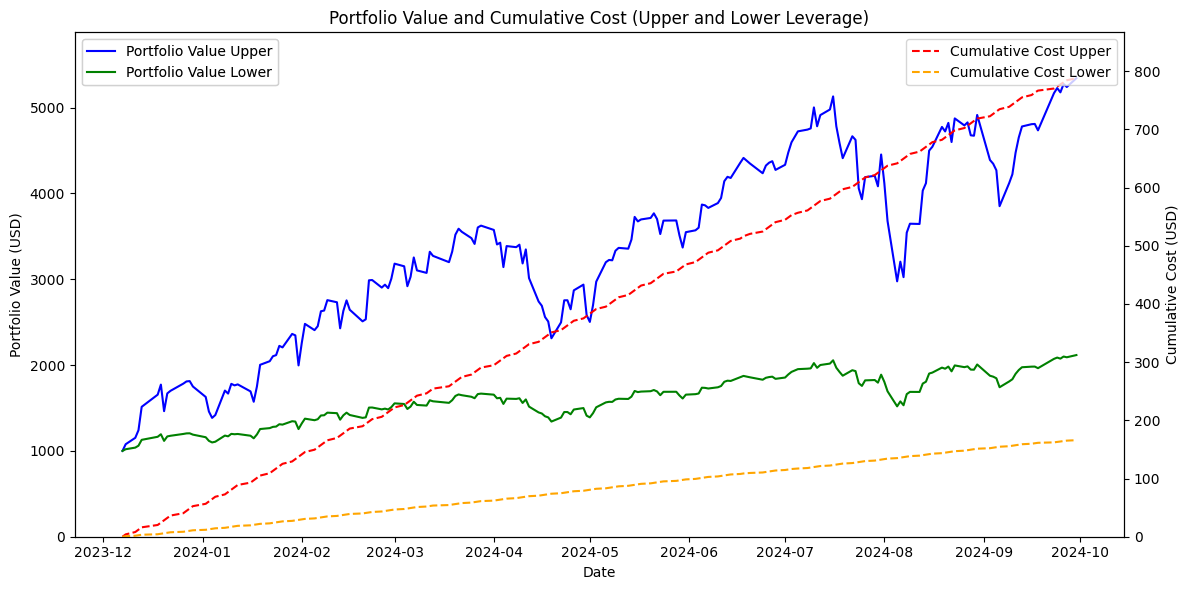

In [3]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title("Portfolio Value and Cumulative Cost (Upper and Lower Leverage)")
ax1.plot(result_df['Date'], result_df['Portfolio_Value_Upper'], color='b', label='Portfolio Value Upper', linewidth=1.5)
ax1.plot(result_df['Date'], result_df['Portfolio_Value_Lower'], color='g', label='Portfolio Value Lower', linewidth=1.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value (USD)")
ax1.set_ylim(0, max(result_df[['Portfolio_Value_Upper', 'Portfolio_Value_Lower']].max()) * 1.1) 

portfolio_legend = ax1.legend(loc="upper left")
ax1.add_artist(portfolio_legend)

ax2 = ax1.twinx()
ax2.plot(result_df['Date'], result_df['Cumulative_Cost_Upper'], color='r', label='Cumulative Cost Upper', linestyle='--', linewidth=1.5)
ax2.plot(result_df['Date'], result_df['Cumulative_Cost_Lower'], color='orange', label='Cumulative Cost Lower', linestyle='--', linewidth=1.5)
ax2.set_ylabel("Cumulative Cost (USD)")
ax2.set_ylim(0, max(result_df[['Cumulative_Cost_Upper', 'Cumulative_Cost_Lower']].max()) * 1.1)

cumulative_cost_legend = ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()
